# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install catboost

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
import time
#import optuna

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

pd.options.mode.chained_assignment = None

import seaborn as sns
import os

In [3]:
# загрузка данных
if os.path.exists('/datasets/autos.csv'):
    df = pd.read_csv('/datasets/autos.csv')

else:
    df = pd.read_csv('/Users/olesya/datasets/autos.csv')


In [4]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Проверим данные на дубликаты

In [6]:
df.duplicated().sum()

4

Итак, данные состоят из 16 колонок и 354369 строк, есть пропуски и 4 дубликата. Избавимся от дубликатов, а также удалим неинформативные столбцы, которые не пригодятся нам для дальнейшего исследования.

- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [7]:
# Удаление дубликатов
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [8]:
# Удаление столбцов
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
df.head()


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


После удаления ненужных столбцов, у нас снова появились дубликаты, у которых отличались только данные DateCrawled или LastSeen. Удалим эти данные, чтобы не путать нашу модель

In [9]:
# Удаление дубликатов
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Посмотрим на выбросы и проверим нет ли аномалий в данных.

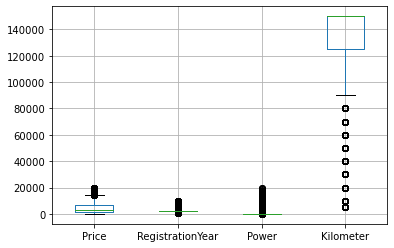

In [11]:
df.boxplot();

Аномалии всё же есть, будем обрбабатывать. 

- Price - цена должна быть и она не может равняться 0
- Power - мощность (л.с.) тоже не может равняться 0

Оставим данные с ценой больше 100 и мощностью больше 5.

In [12]:
cars = df[(df['Price']>100) & (df['Power']>5)]

В столбце RegistrationYear также аномальные данные, год регистрации не может быть 1234 или 9999. Поэтому оставим период с 1900 по 2016 гг, так как анкеты были скачены март-апрель 2016 и год регистрации не может быть позже заполнения анкеты.

In [13]:
cars = cars[(cars['RegistrationYear']<2016) & (cars['RegistrationYear']>1900)]
cars.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [14]:
# Проверка пропусков
cars.isna().sum()

Price                   0
VehicleType          4422
RegistrationYear        0
Gearbox              4571
Power                   0
Model                9692
Kilometer               0
FuelType            12324
Brand                   0
NotRepaired         36680
dtype: int64

Заменим пропуски на нетепичное значение "other", так модель воспримет их как отдельную категорию

In [15]:
cars.fillna('other', inplace=True)

In [16]:
cars.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

В столбце FuelType объединим категории petrol и gasoline, а также lpg и cng, потому что по сути это одно и тоже.

In [17]:
cars['FuelType'].value_counts()

petrol      157883
gasoline     74807
other        12406
lpg           4231
cng            436
hybrid         187
electric        61
Name: FuelType, dtype: int64

In [18]:
cars['FuelType'] = cars['FuelType'].replace('gasoline', 'petrol')
cars['FuelType'] = cars['FuelType'].replace('cng', 'lpg')

В столбце Model объединим категории range_rover_evoque и rangerover.

In [19]:
cars['Model'] = cars['Model'].replace('range_rover_evoque', 'rangerover')

In [20]:
display(cars.head())
cars.info()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,other,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,other
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 250011 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             250011 non-null  int64 
 1   VehicleType       250011 non-null  object
 2   RegistrationYear  250011 non-null  int64 
 3   Gearbox           250011 non-null  object
 4   Power             250011 non-null  int64 
 5   Model             250011 non-null  object
 6   Kilometer         250011 non-null  int64 
 7   FuelType          250011 non-null  object
 8   Brand             250011 non-null  object
 9   NotRepaired       250011 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.0+ MB


<b>Вывод</b>

Изучили данные. Заполнили пропущенные значения и обработали аномалии в столбцах. Удалили явные дубликаты. Удалили неинформативные данные.
Датасет готов, переходим к обучению.

## Обучение моделей

Задействуем технику порядкого кодирования, чтобы преобразовать категориальные признаки в числа.

In [21]:
encoder = OrdinalEncoder()


In [22]:
cars_oe = cars.copy()
# определение категориальных признаков
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
cars_oe[cat_cols] = encoder.fit_transform(cars[cat_cols])
cars_oe.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,2.0,2011,1.0,190,166.0,125000,4.0,1.0,2.0
2,9800,6.0,2004,0.0,163,117.0,125000,4.0,14.0,1.0
3,1500,5.0,2001,1.0,75,116.0,150000,4.0,38.0,0.0
4,3600,5.0,2008,1.0,69,101.0,90000,4.0,31.0,0.0
5,650,4.0,1995,1.0,102,11.0,150000,4.0,2.0,2.0


Подготовим признаки и целевой признак, а затем разделим данные на обучающую, валидационную и тестовую выборки.

In [23]:
features_oe = cars_oe.drop('Price', axis=1)
target_oe = cars_oe['Price']

In [24]:
# деление данных на обучающую, валидационную и тестовую выборки
features_train, features_rest, target_train, target_rest = train_test_split(
    features_oe, target_oe, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_rest, target_rest, test_size=0.5, random_state=12345)


Стандартизируем данные методом масштабирования

In [25]:
# Масштабирование данных
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


In [26]:
features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
284599,4.0,-1.629285,1.0,-0.386216,151.0,-0.724818,4.0,23.0,2.0
232453,4.0,0.683826,1.0,0.235943,116.0,0.612580,4.0,38.0,0.0
259612,4.0,-0.704040,1.0,-0.219950,17.0,0.612580,4.0,19.0,1.0
224882,7.0,0.529618,0.0,0.198399,11.0,0.612580,4.0,2.0,0.0
233096,5.0,1.300655,0.0,-0.203859,123.0,-2.597176,1.0,11.0,0.0


Обучим и проанализируем время работы и качество моделей. 

Для этого рассмотрим 4 модели: 
- LinearRegression
- DecisionTreeRegressor
- LightGBM
- CatBoost

In [27]:
#  функция вычисления rmse
def rmse(target, predicted):
    mse = mean_squared_error(target, predicted) 
    return mse ** 0.5


In [28]:
# создание итоговой таблицы
models= pd.DataFrame(columns = ['model', 'rmse'])

<b>LinearRegression</b>

In [29]:
model_lr = LinearRegression()

In [30]:
%%time
model_lr.fit(features_train, target_train)

CPU times: user 83.7 ms, sys: 64.1 ms, total: 148 ms
Wall time: 159 ms


LinearRegression()

In [31]:
%%time
predicted_valid_lr = model_lr.predict(features_valid)

CPU times: user 8.69 ms, sys: 13.2 ms, total: 21.9 ms
Wall time: 27.8 ms


In [32]:
rmse_lr = rmse(target_valid, predicted_valid_lr)
print("RMSE модели LinearRegression =", rmse_lr)

RMSE модели LinearRegression = 3522.083907386441


In [33]:
# добавление результата в итоговую таблицу
models = models.append({'model': 'LinearRegression', 'rmse': rmse_lr}, ignore_index=True)

<b>DecisionTreeRegressor</b>

In [34]:
model_tree = DecisionTreeRegressor(random_state=12345)

In [35]:
# определение гиперпараметров
params = {'max_depth':np.arange(1,15),
         'min_samples_split':np.arange(2,11),
         'min_samples_leaf':np.arange(1,11)}

In [36]:
# поиск наилучшей модели
search = RandomizedSearchCV(estimator=model_tree, param_distributions=params, cv=3)
search.fit(features_train, target_train)
best_tree = search.best_estimator_
best_tree

DecisionTreeRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=5,
                      random_state=12345)

In [37]:
model_tree_best = DecisionTreeRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=5, 
                                   random_state=12345)

In [39]:

%%time
model_tree_best.fit(features_train, target_train)

CPU times: user 457 ms, sys: 5.4 ms, total: 462 ms
Wall time: 463 ms


DecisionTreeRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=5,
                      random_state=12345)

In [40]:
%%time
predicted_valid_tree = model_tree_best.predict(features_valid)

CPU times: user 15.8 ms, sys: 13.7 ms, total: 29.5 ms
Wall time: 26.8 ms


In [41]:
rmse_tree_best = rmse(target_valid, predicted_valid_tree)
print("RMSE модели DecisionTreeRegressor =", rmse_tree_best)

RMSE модели DecisionTreeRegressor = 1863.351649938096


In [42]:
# добавление результата в итоговую таблицу
models = models.append({'model': 'DecisionTreeRegressor', 'rmse': rmse_tree_best}, 
                       ignore_index=True)

<b>LGBMRegressor</b>

In [43]:
# определение гиперпараметров
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 10, 
    'learning_rate': 0.1,
    'verbose': 0
}

In [44]:
model_lgbm = LGBMRegressor(**params)

In [45]:
%%time
model_lgbm.fit(features_train, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
CPU times: user 2.9 s, sys: 137 ms, total: 3.04 s
Wall time: 981 ms


LGBMRegressor(max_depth=10, metric='rmse', objective='regression', verbose=0)

In [46]:
%%time
predicted_valid_lgbm = model_lgbm.predict(features_valid)

CPU times: user 741 ms, sys: 8.09 ms, total: 749 ms
Wall time: 235 ms


In [47]:
rmse_lgbm = rmse(target_valid, predicted_valid_lgbm)
print("RMSE модели LGBMRegressor =", rmse_lgbm)

RMSE модели LGBMRegressor = 1689.0653339117493


In [48]:
# добавление результата в итоговую таблицу
models = models.append({'model': 'LGBMRegressor', 'rmse': rmse_lgbm}, ignore_index=True)

<b>CatBoostRegressor</b>

In [49]:
model_cat = CatBoostRegressor(iterations=100, loss_function="RMSE")

In [50]:
%%time
model_cat.fit(features_train, target_train, verbose=False) 

CPU times: user 4.43 s, sys: 261 ms, total: 4.69 s
Wall time: 2.25 s


In [51]:
%%time
predicted_valid_cat = model_cat.predict(features_valid)

CPU times: user 29.2 ms, sys: 4.05 ms, total: 33.3 ms
Wall time: 30.7 ms


In [52]:
rmse_cat = rmse(target_valid, predicted_valid_cat)
print("RMSE модели CatBoost =", rmse_cat)

RMSE модели CatBoost = 1678.756000802963


In [53]:
# добавление результата в итоговую таблицу
models = models.append({'model': 'CatBoostRegressor', 'rmse': rmse_cat}, ignore_index=True)

## Анализ моделей

Выведем общую таблицу по времени работы обучения и предсказаний разных моделей и сравним результаты

In [54]:
models['train_time, sec'] = ['0.16', '0.46', '0.98', '2.25']

In [55]:
models['predict_time, msec'] = ['27.8', '26.8', '235', '30.7']

In [56]:
models

,model,rmse,"train_time, sec","predict_time, msec"
0,LinearRegression,3522.083907,0.16,27.8
1,DecisionTreeRegressor,1863.351650,0.46,26.8
2,LGBMRegressor,1689.065334,0.98,235
3,CatBoostRegressor,1678.756001,2.25,30.7


Наилучший результат метрики RMSE на валидационной выборке показала модель CatBoostRegressor. Проверим эту модель на тестовой выборке. Перед этим создадим новую обучающую выборку, объединив выборки train+valid.

In [57]:
# объединение двух выборок для заключительного теста
features_new = features_train.append(features_valid, ignore_index=True)
target_new = target_train.append(target_valid, ignore_index=True)

In [58]:
# catboost
model = CatBoostRegressor(iterations=100, loss_function="RMSE")

In [59]:
%%time
model.fit(features_new, target_new, verbose=False) 

CPU times: user 5.62 s, sys: 253 ms, total: 5.87 s
Wall time: 2.52 s


In [60]:
%%time
predicted = model.predict(features_test)

CPU times: user 29.3 ms, sys: 11.8 ms, total: 41.1 ms
Wall time: 33.4 ms


In [61]:
rmse = rmse(target_test, predicted)
print("RMSE модели CatBoost =", rmse)

RMSE модели CatBoost = 1663.0177682891756


На тестовой выборке получили такие же результаты, как и на валидационной.

### Вывод 



Модели градиентного бустинга показали результаты лучше, чем модели линейной регрессии и дерева решений. Быстрее всего обучается модель линейной регрессии, но ее точность оставляет желать лучшего. LGBMRegressor показала второй результат по точности, но время обучения и предсказания слишком долгое.

Самую лучшую метрику RMSE показала модель CatBoostRegressor, также время предсказания у неё в разы меньше, чем у LGBMRegressor.
